In [1]:
# update the git
! git add  .
! git commit -m "From Mac"
! git push

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
Everything up-to-date


In [2]:
# import library
import tensorflow as tf
import matplotlib 
matplotlib.use('Agg')
%matplotlib inline
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [3]:
# get the fashion mnist data set
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((20000,28,28,1))
test_batch = np.zeros((10000,28,28,1))
for x in range(20000):
    train_batch[x,:,:,:] = np.expand_dims(resize(x_data[x,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


(20000, 28, 28, 1)
1.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
0.0
0.0
(10000, 10)
1.0
0.0


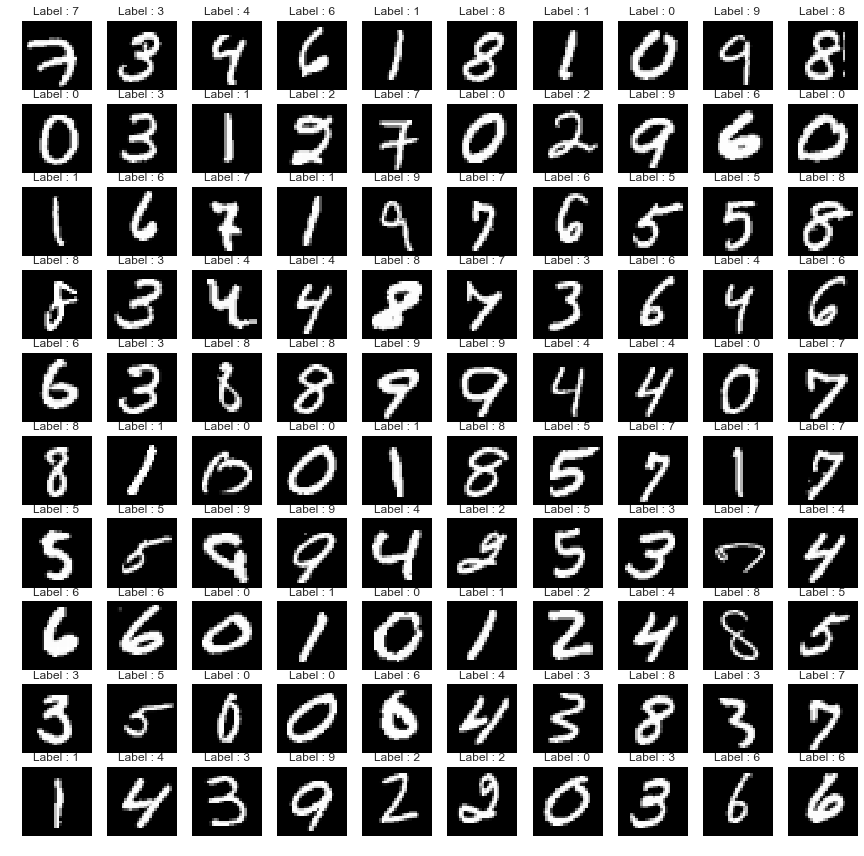

In [4]:
# show small amount of fashion
fig=plt.figure(figsize=(15, 15))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title("Label : "+str(np.argmax(train_label[i-1])))
plt.show()

In [111]:
# import all of the layers
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_identiy(x): return x
def d_tf_identiy(x): return tf.ones_like(x,dtype=tf.float32)

def tf_relu(x): return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0.0),tf.float32)

def tf_lrelu(x): return tf.nn.leaky_relu(x,alpha=0.2)
def d_tf_lrelu(x): return tf.cast(tf.greater(x,0),tf.float32) + tf.cast(tf.less_equal(x,0),tf.float32) * 0.2

def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x): return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x): return x
def d_tf_iden(x): return 1.0

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x): return tf.sqrt(x ** 2 + 1e-20)

def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class FNN():

    def __init__(self,inc,outc,act=tf_elu,d_act=d_tf_elu,stddev=0.005,special_init=False,which_reg=0.0):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float32,seed=2))
            self.b = tf.Variable(tf.zeros(shape=[outc],dtype=tf.float32))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc],stddev=stddev,seed=2,dtype=tf.float32))
            self.b = tf.Variable(tf.zeros([outc],dtype=tf.float32))

        self.m,  self.v   = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.m_b,self.v_b = tf.Variable(tf.zeros_like(self.b)),tf.Variable(tf.zeros_like(self.b))
        
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w) 
        self.layerA = self.act(self.layer) 
        return self.layerA

    def backprop(self,gradient=None,which_reg=0,learning_rate=0.0008):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad  = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_b= tf.reduce_mean(grad_middle,0)
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        # === Reg ===        
        if self.which_reg == 0:
            grad  = grad
            grad_b= grad_b

        if self.which_reg == 0.5:
            grad  = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
            grad_b= grad_b+lamda * (tf.sqrt(tf.abs(self.b))) * (1.0/tf.sqrt(tf.abs(self.b)+ 10e-5)) * tf.sign(self.b)

        if self.which_reg == 1:
            grad = grad   + lamda * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.sign(self.b)

        if self.which_reg == 1.5:
            grad = grad   + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
            grad_b=grad_b + lamda * 1.0/(tf.sqrt(tf.square(self.b) + 10e-5)) * self.b

        if self.which_reg == 2:
            grad = grad  + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
            grad_b=grad_b+ lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.b))+ 10e-5)) * tf.abs(self.b) * tf.sign(self.b)

        if self.which_reg == 2.5:
            grad = grad   + lamda * 2.0 * self.w

        if self.which_reg == 3:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.b),2) * tf.sign(self.b)

        if self.which_reg == 4:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.b),3) * tf.sign(self.b)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1.-beta1)
        v_hat = self.v / (1.-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))

        update_w.append(tf.assign(self.m_b,self.m_b*beta1 + (1-beta1) * (grad_b)   ))
        update_w.append(tf.assign(self.v_b,self.v_b*beta2 + (1-beta2) * (grad_b ** 2)   ))
        m_hat_b = self.m_b / (1-beta1)
        v_hat_b = self.v_b / (1-beta2)
        adam_middle_b = m_hat_b *  learning_rate/(tf.sqrt(v_hat_b) + adam_e)
        update_w.append(tf.assign(self.b,tf.subtract(self.b,adam_middle_b ))) 
        
        return grad_pass,update_w

class CNN():

    def __init__(self,k,inc,out,stddev=0.005,which_reg=0,act=tf_elu,d_act=d_tf_elu,residual=False):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg
        self.residual = residual

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        if self.residual: 
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding='SAME')
            self.layerA = self.act(self.layer) + input
        else:
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
            self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        if self.residual: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) / batch_size
            
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) + gradient
        else: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            ) / batch_size
        
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            )

        # === Reg ===        
        if self.which_reg == 0:
            grad = grad

        if self.which_reg == 0.5:
            grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)

        if self.which_reg == 1:
            grad = grad + lamda * tf.sign(self.w)

        if self.which_reg == 1.5:
            grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w

        if self.which_reg == 2:
            grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)

        if self.which_reg == 2.5:
            grad = grad + lamda * 2.0 * self.w

        if self.which_reg == 3:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)

        if self.which_reg == 4:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

In [112]:
# hyper class
num_epoch = 101; batch_size = 500; print_size = 1; lamda = 0.000001
beta1,beta2,adam_e = 0.9,0.999,10e-8
eps = 10e-10

x = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)
x_discrim = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)
z = tf.placeholder(shape=[batch_size,2],dtype=tf.float32)

e1 = FNN(784,1000,       which_reg=2.5,act=tf_relu,d_act=d_tf_relu)
e2 = FNN(1000,1000,      which_reg=2.5,act=tf_relu,d_act=d_tf_relu)
e3 = FNN(1000,2,         which_reg=2.5,act=tf_identiy,d_act=d_tf_identiy)

d1 = FNN(2,1000,         which_reg=2.5,act=tf_relu,d_act=d_tf_relu)
d2 = FNN(1000,1000,      which_reg=2.5,act=tf_relu,d_act=d_tf_relu)
d3 = FNN(1000,784,       which_reg=2.5,act=tf_sigmoid,d_act=d_tf_sigmoid)

discrim1 = FNN(2,1000   ,which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
discrim2 = FNN(1000,1000,which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
discrim3 = FNN(1000,1   ,which_reg=0.0,act=tf_sigmoid,d_act=d_tf_sigmoid)

In [113]:
# Update the discriminator
dis_learning_rate = tf.placeholder(shape=[],dtype=tf.float32)
dis_elayer1 = e1.feedforward(x_discrim)
dis_elayer2 = e2.feedforward(dis_elayer1)
dis_elayer3 = e3.feedforward(dis_elayer2)

# One -> Labeled as encoded, Zero -> Aimed Labeled
dis_input     = tf.concat([dis_elayer3,z],0)
dis_true_label= tf.concat([tf.zeros([batch_size,1]),tf.ones([batch_size,1])],axis=0)
dis_dislayer1 = discrim1.feedforward(dis_input)
dis_dislayer2 = discrim2.feedforward(dis_dislayer1)
dis_dislayer3 = discrim3.feedforward(dis_dislayer2)

dis_cost = - tf.reduce_mean(
    dis_true_label * tf.log(dis_dislayer3+eps) + (1.-dis_true_label) * tf.log((1.-dis_dislayer3)+eps)
)

dis_grad = (-(dis_true_label/(dis_dislayer3+eps)) + (1.-dis_true_label)/((1.-dis_dislayer3)+eps))/(2.*batch_size)

dis_grad3,dis_grad3_up = discrim3.backprop(dis_grad,learning_rate=dis_learning_rate)
dis_grad2,dis_grad2_up = discrim2.backprop(dis_grad3,learning_rate=dis_learning_rate)
dis_grad1,dis_grad1_up = discrim1.backprop(dis_grad2,learning_rate=dis_learning_rate)

dis_grad_update = dis_grad3_up + dis_grad2_up + dis_grad1_up

print(dis_elayer1,dis_elayer2)
print(dis_elayer3)
print(dis_input,dis_true_label)
print(dis_dislayer1,dis_dislayer2)
print(dis_dislayer3)
print('------------------')
print(dis_grad)
print(dis_grad3,dis_grad2)
print(dis_grad1)

Tensor("Relu_252:0", shape=(500, 1000), dtype=float32) Tensor("Relu_253:0", shape=(500, 1000), dtype=float32)
Tensor("MatMul_816:0", shape=(500, 2), dtype=float32)
Tensor("concat_48:0", shape=(1000, 2), dtype=float32) Tensor("concat_49:0", shape=(1000, 1), dtype=float32)
Tensor("Relu_254:0", shape=(1000, 1000), dtype=float32) Tensor("Relu_255:0", shape=(1000, 1000), dtype=float32)
Tensor("Sigmoid_191:0", shape=(1000, 1), dtype=float32)
------------------
Tensor("truediv_1669:0", shape=(1000, 1), dtype=float32)
Tensor("MatMul_821:0", shape=(1000, 1000), dtype=float32) Tensor("MatMul_823:0", shape=(1000, 1000), dtype=float32)
Tensor("MatMul_825:0", shape=(1000, 2), dtype=float32)


In [114]:
# update encoder / decoder / fake label
learning_rate = tf.placeholder(shape=[],dtype=tf.float32)
elayer1 = e1.feedforward(x)
elayer2 = e2.feedforward(elayer1)
elayer3 = e3.feedforward(elayer2)

dlayer1 = d1.feedforward(elayer3)
dlayer2 = d2.feedforward(dlayer1)
dlayer3 = d3.feedforward(dlayer2)

fake_label= tf.ones([batch_size,1])
fake_dis1 = discrim1.feedforward(elayer3)
fake_dis2 = discrim2.feedforward(fake_dis1)
fake_dis3 = discrim3.feedforward(fake_dis2)

fake_bin_c = - tf.reduce_mean(
    fake_label * tf.log(fake_dis3+eps) + (1.-fake_label) * tf.log((1.-fake_dis3)+eps)
)
recon_cost = tf.reduce_mean(tf.square(dlayer3-x))
total_cost = fake_bin_c + recon_cost

recon_grad = (dlayer3 - x) / (batch_size)
fake_grad  = (-(fake_label/(fake_dis3+eps)) + (1.-fake_label)/((1.-fake_dis3)+eps))/(batch_size)

dgrad3,dgrad3_up = d3.backprop(recon_grad,learning_rate=learning_rate)
dgrad2,dgrad2_up = d2.backprop(dgrad3,learning_rate=learning_rate)
dgrad1,dgrad1_up = d1.backprop(dgrad2,learning_rate=learning_rate)

fake_grad3,_ = discrim3.backprop(fake_grad)
fake_grad2,_ = discrim2.backprop(fake_grad3)
fake_grad1,_ = discrim1.backprop(fake_grad2)

fake_grad1_norm = (fake_grad1 - tf.reduce_min(fake_grad1,1)[:,None]) /(tf.reduce_max(fake_grad1,1)-tf.reduce_min(fake_grad1,1))[:,None]
dgrad1_norm = (dgrad1 - tf.reduce_min(dgrad1,1)[:,None]) /(tf.reduce_max(dgrad1,1)-tf.reduce_min(dgrad1,1))[:,None]

mid_grad = (fake_grad1_norm + dgrad1_norm) * 0.5
egrad3,egrad3_up = e3.backprop(mid_grad,learning_rate=learning_rate)
egrad2,egrad2_up = e2.backprop(egrad3,learning_rate=learning_rate)
egrad1,egrad1_up = e1.backprop(egrad2,learning_rate=learning_rate)

grad_update = dgrad3_up + dgrad2_up + dgrad1_up + egrad3_up + egrad2_up + egrad1_up

print(elayer1,elayer2)
print(elayer3)
print(egrad3,egrad2)
print(egrad1)

print(dlayer1,dlayer2)
print(dlayer3)
print(dgrad3,dgrad2)
print(dgrad1)

print(fake_dis1,fake_dis2)
print(fake_dis3)
print(fake_grad3,fake_grad2)
print(fake_grad1)

Tensor("Relu_256:0", shape=(500, 1000), dtype=float32) Tensor("Relu_257:0", shape=(500, 1000), dtype=float32)
Tensor("MatMul_828:0", shape=(500, 2), dtype=float32)
Tensor("MatMul_848:0", shape=(500, 1000), dtype=float32) Tensor("MatMul_850:0", shape=(500, 1000), dtype=float32)
Tensor("MatMul_852:0", shape=(500, 784), dtype=float32)
Tensor("Relu_258:0", shape=(500, 1000), dtype=float32) Tensor("Relu_259:0", shape=(500, 1000), dtype=float32)
Tensor("Sigmoid_194:0", shape=(500, 784), dtype=float32)
Tensor("MatMul_836:0", shape=(500, 1000), dtype=float32) Tensor("MatMul_838:0", shape=(500, 1000), dtype=float32)
Tensor("MatMul_840:0", shape=(500, 2), dtype=float32)
Tensor("Relu_260:0", shape=(500, 1000), dtype=float32) Tensor("Relu_261:0", shape=(500, 1000), dtype=float32)
Tensor("Sigmoid_195:0", shape=(500, 1), dtype=float32)
Tensor("MatMul_842:0", shape=(500, 1000), dtype=float32) Tensor("MatMul_844:0", shape=(500, 1000), dtype=float32)
Tensor("MatMul_846:0", shape=(500, 2), dtype=float32

 iter: 0 batch: 19500 recon cost: 0.6929381 discrim cost: 0.925206665

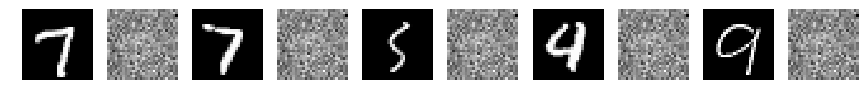

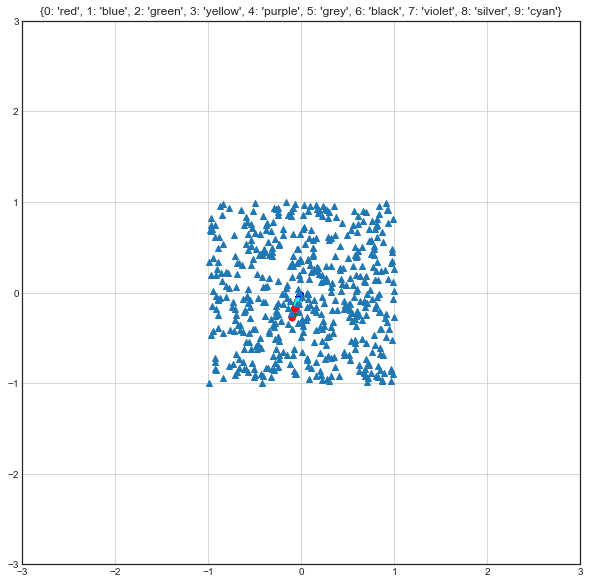

 iter: 1 batch: 19500 recon cost: 0.69275856 discrim cost: 0.92484327

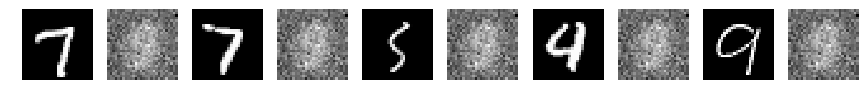

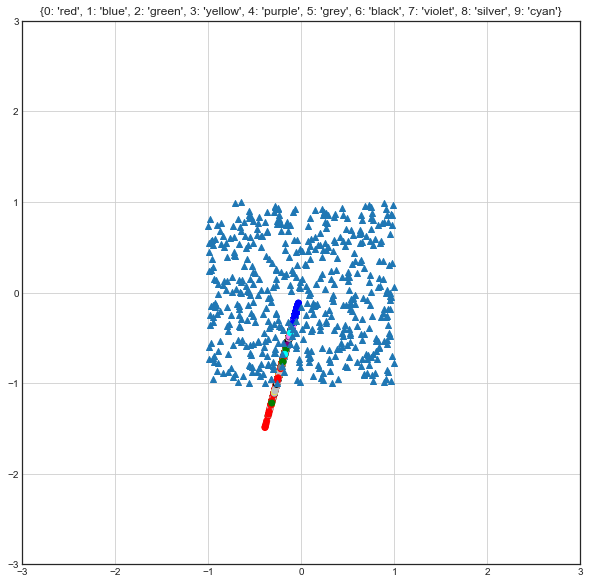

 iter: 2 batch: 19500 recon cost: 0.69201297 discrim cost: 0.92479586

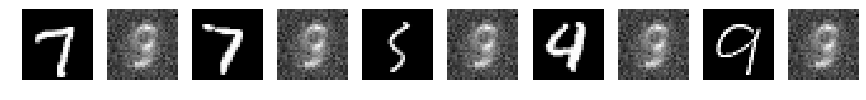

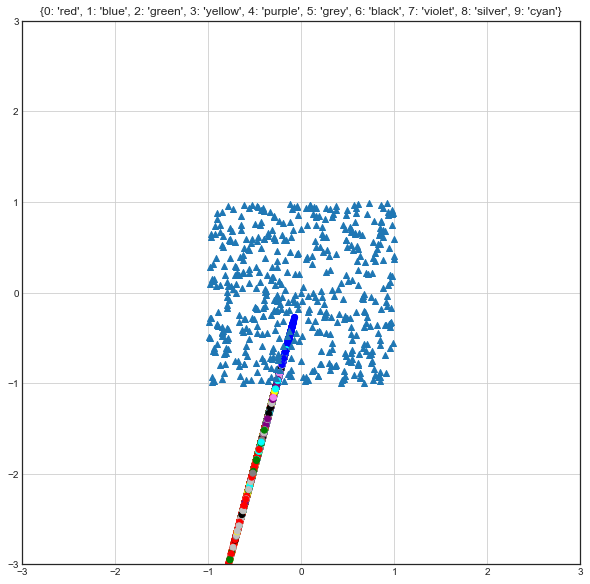

 iter: 3 batch: 3000 recon cost: 0.6917815 discrim cost: 0.92422014

KeyboardInterrupt: 

In [115]:
# start the session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_batch_shuffled = train_batch.copy()
color_dict = {0:'red',1:'blue',2:'green',3:'yellow',4:'purple',5:'grey',6:'black',7:'violet',8:'silver',9:'cyan'}

for iter in range(num_epoch):
    
#     train_batch_shuffled = shuffle(train_batch_shuffled)
    for current_data_index in range(0,len(train_batch),batch_size):
        current_data = train_batch_shuffled[current_data_index:current_data_index+batch_size].astype(np.float32)
        prior_z      = np.random.uniform(low=-1.0, high=1.0,size=(batch_size, 2)).astype(np.float32)
    
        sess_result1 = sess.run([dis_cost,dis_grad_update],
        feed_dict={
            x_discrim:current_data.reshape((batch_size,-1)),
            z:prior_z,
            dis_learning_rate:0.00002
        })
       
        sess_result2 = sess.run([total_cost,grad_update],
        feed_dict={
            x:current_data.reshape((batch_size,-1)),
            learning_rate:0.00001
        })

        sys.stdout.write(
            '\r iter: ' + str(iter) + ' batch: ' + str(current_data_index) + \
            ' recon cost: ' + str(sess_result1[0]) + ' discrim cost: ' + str(sess_result2[0]) 
        ); sys.stdout.flush()
        
    if iter % print_size == 0:
        
        sess_result = sess.run(dlayer3,feed_dict={x:current_data.reshape((batch_size,-1))}).reshape((batch_size,28,28))
        fig=plt.figure(figsize=(15, 15))
        columns = 10 ; rows = 1
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            if i % 2 ==0 :
                  plt.imshow(np.squeeze(sess_result[i-2]),cmap='gray')
            else:
                plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
            plt.axis('off')
        plt.show()
        
        # Show the latent space        
        all_latent_vectors = sess.run(elayer3,feed_dict={x:train_batch[:batch_size].reshape((batch_size,-1))})
        for current_batch_index in range(batch_size,len(train_batch), batch_size):
            current_train_data = train_batch[current_batch_index:current_batch_index+batch_size]
            sess_results = sess.run(elayer3,feed_dict={x:current_train_data.reshape((batch_size,-1))})
            all_latent_vectors = np.vstack((all_latent_vectors,sess_results))
        fig = plt.figure(figsize=(10,10))
        color_mapping = [color_dict[x] for x in np.argmax(train_label[:len(train_batch),:],1) ]
        plt.title(str(color_dict))
        plt.scatter(all_latent_vectors[:,0],all_latent_vectors[:,1],c=color_mapping)
        plt.scatter(prior_z[:,0],prior_z[:,1],marker='^')
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plt.grid()
        plt.show()

In [ ]:
# convert every data into latent to know the statistics
all_latent_vectors = sess.run(elayer3,feed_dict={x:train_batch[:batch_size].reshape((batch_size,-1))})
print(train_batch.shape)
print(all_latent_vectors.shape)
for current_batch_index in range(batch_size,len(train_batch), batch_size):
    current_train_data = train_batch[current_batch_index:current_batch_index+batch_size]
    sess_results = sess.run(elayer3,feed_dict={x:current_train_data.reshape((batch_size,-1))})
    all_latent_vectors = np.vstack((all_latent_vectors,sess_results))
print(all_latent_vectors.shape)

In [ ]:
# view the latent vectors
fig = plt.figure(figsize=(10,10))
color_dict = {
    0:'red',
    1:'blue',
    2:'green',
    3:'yellow',
    4:'purple',
    5:'grey',
    6:'black',
    7:'violet',
    8:'silver',
    9:'cyan',
}
color_mapping = [color_dict[x] for x in np.argmax(train_label[:len(train_batch),:],1) ]
plt.title(str(color_dict))
plt.scatter(all_latent_vectors[:,0],all_latent_vectors[:,1],c=color_mapping)
plt.grid()
plt.show()